In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))


In [2]:
from data.dataset import CoDeTM4

In [3]:
train, val, test  = CoDeTM4('../../data/').get_dataset(['train','val','test'], columns='all', dynamic_split_sizing=False)

In [4]:
from datasets import concatenate_datasets

In [5]:
codet = concatenate_datasets([train, val, test])

In [3]:
import tree_sitter_python as tspython
import tree_sitter_cpp as tscpp
import tree_sitter_java as tsjava
from tree_sitter import Parser, Language

TS_PYTHON = Language(tspython.language())
TS_JAVA = Language(tsjava.language())
TS_CPP = Language(tscpp.language())

PYTHON_PARSER, JAVA_PARSER, CPP_PARSER = Parser(language=TS_PYTHON), Parser(language=TS_JAVA), Parser(language=TS_CPP)

In [7]:
import re

TOKEN_REGEX = re.compile(r'''
    # --- STRING LITERALS ---
    ("(?:\\.|[^"\\])*" | '(?:\\.|[^'\\])*') |

    # --- COMMENTS (Python/Java/C++) ---
    (//[^\n]* | \#[^\n]* | /\*.*?\*/ ) |

    # --- OPERATORS & SYMBOLS ---
    (\+\+|--|==|!=|<=|>=|&&|\|\||::|->|[=+\-*/%<>!&|^~?:;.,()[\]{}]) |

    # --- NUMBERS ---
    (\b\d+(?:\.\d+)?\b) |

    # --- IDENTIFIERS / VARIABLES / KEYWORDS ---
    (\b[a-zA-Z_]\w*\b)
''', re.VERBOSE | re.DOTALL)

def tokenize_code(code):
    tokens = []
    for match in TOKEN_REGEX.finditer(code):
        token = match.group(0)
        tokens.append(token)
    return tokens

In [8]:
import matplotlib.pyplot as plt

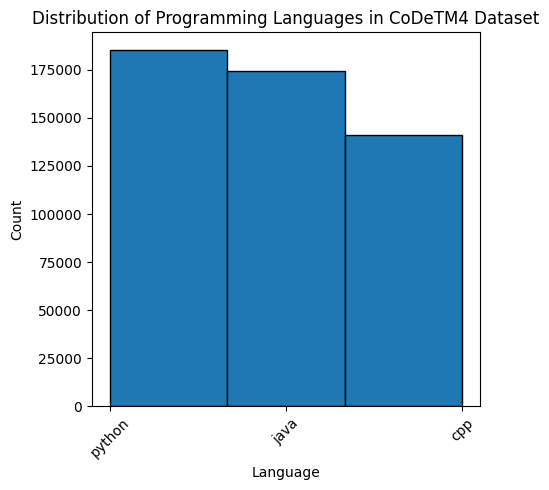

Python count: 185163
Java count: 174169
C++ count: 141220


In [9]:
language_counts = codet['language']
plt.figure(figsize=(5, 5))
plt.hist(language_counts, bins=len(set(language_counts)), edgecolor='black')
plt.xlabel('Language')
plt.ylabel('Count')
plt.title('Distribution of Programming Languages in CoDeTM4 Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

python_count = language_counts.count("python")
java_count = language_counts.count("java")
cpp_count = language_counts.count("cpp")

print(f'Python count: {python_count}')
print(f'Java count: {java_count}')
print(f'C++ count: {cpp_count}')

In [10]:
from itertools import islice

vectorizer_samples = list(
    islice(
        (sample for sample in codet if sample['language'] == 'python'),
        int(0.1*python_count)
    )
)

vectorizer_samples.extend(
    list(
        islice(
            (sample for sample in codet if sample['language'] == 'java'),
            int(0.1*java_count)
        )
    )
)
vectorizer_samples.extend(
    list(
        islice(
            (sample for sample in codet if sample['language'] == 'cpp'),
            int(0.1*cpp_count)
        )
    )
)

In [11]:
len(vectorizer_samples) == int(0.1*python_count) + int(0.1*java_count) + int(0.1*cpp_count)

True

In [4]:
def get_parser(language):
    match language:
        case 'python':
            return PYTHON_PARSER
        case 'java':
            return JAVA_PARSER
        case 'cpp':
            return CPP_PARSER
    raise ValueError(f"Unsupported language: {language}")

In [5]:
def create_tree(sample, code_key='cleaned_code'):
    language = sample['language']
    parser = get_parser(language)
    tree = parser.parse(bytes(sample[code_key], 'utf-8'))
    return tree

In [14]:
tree = create_tree(codet[0])

In [15]:
tree.walk()

In [ ]:
from tree_sitter import TreeCursor

def walk_tree(cursor: TreeCursor, depth=0):
    indent = '  ' * depth
    print(f"{indent}{cursor.node.type}")

    if cursor.goto_first_child():
        walk_tree(cursor, depth+1)
    
        while cursor.goto_next_sibling():
            walk_tree(cursor, depth+1)

        cursor.goto_parent()

cursor = tree.walk()
walk_tree(cursor)

In [8]:
from typing import Set

def get_node_types_from_tree(cursor: TreeCursor, types: Set[str]=None) -> Set[str]:
    if types is None:
        types = set()
    
    types.add(cursor.node.type)

    if cursor.goto_first_child():
        get_node_types_from_tree(cursor, types)
    
        while cursor.goto_next_sibling():
            get_node_types_from_tree(cursor, types)

        cursor.goto_parent()

    return types

In [18]:
cursor = tree.walk()
types = get_node_types_from_tree(cursor)

In [19]:
len(types)

68

In [20]:
def extract_types(sample):
    parser = get_parser(sample['language'])
    tree = parser.parse(sample['cleaned_code'].encode('utf-8'))
    cursor = tree.walk()
    types = get_node_types_from_tree(cursor)
    return {"types": list(types)}

result = codet.map(extract_types, batched=False, num_proc=8)

all_types = set()
for tlist in result['types']:
    all_types.update(tlist)

print(f"Collected {len(all_types)} unique node types")

Parameter 'function'=<function extract_types at 0x7e4535eb3250> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
2025-07-27 03:48:57,517 - WARNING - Parameter 'function'=<function extract_types at 0x7e4535eb3250> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute

Map (num_proc=8):   0%|          | 0/500552 [00:00<?, ? examples/s]

Collected 563 unique node types


In [21]:
all_types = sorted(list(all_types))

In [22]:
type_to_ind = {t: i for i, t in enumerate(all_types)}

In [23]:
from torch_geometric.data import Data
from typing import List, Tuple, Dict
from tree_sitter import Node

In [9]:
from torch_geometric.data import Data
from typing import List, Tuple, Dict
import torch
from tree_sitter import TreeCursor

def tree_to_graph(cursor: TreeCursor, id_map: Dict = None, next_id: int = 0, edges: List[Tuple[int, int]] = None) -> Tuple[List[Tuple[int, int]], Dict, int]:
    if edges is None:
        edges = []
    if id_map is None:
        id_map = {}

    # Assign ID to current node
    if cursor.node not in id_map:
        id_map[cursor.node] = next_id
        next_id += 1
    current_id = id_map[cursor.node]

    if cursor.goto_first_child():
        while True:
            if cursor.node not in id_map:
                id_map[cursor.node] = next_id
                next_id += 1
            child_id = id_map[cursor.node]
            edges.append((current_id, child_id))
            # Recurse
            edges, id_map, next_id = tree_to_graph(cursor, id_map, next_id, edges)
            if not cursor.goto_next_sibling():
                break
        cursor.goto_parent()  # restore parent position

    return edges, id_map, next_id

In [25]:
import h5py
from tqdm import tqdm

In [10]:
def create_graph(sample):
    tree = create_tree(sample)
    edges, id_map, _ = tree_to_graph(tree.walk())
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    x = [type_to_ind[node.type] for node, _ in sorted(id_map.items(), key=lambda kv: kv[1])]
    x = torch.tensor(x, dtype=torch.long)
    y = torch.tensor([sample['target_binary']], dtype=torch.long)

    graph_features = torch.tensor(list(sample['features'].values()))
    
    metadata = {
        'language': sample['language'],
        'target': sample['target'],
        'target_binary': sample['target_binary'],
        'code': sample['code'],
        'cleaned_code': sample['cleaned_code']
    }
    
    data = Data(
        x=x, 
        y=y, 
        edge_index=edge_index, 
        graph_features=graph_features,
        metadata=metadata
    )    
    return data


In [27]:
data = create_graph(codet[0])

In [28]:
print(data.metadata)
print(data.graph_features)

{'language': 'python', 'target': 'human', 'target_binary': 0, 'code': 'def order_phase_diagram(lines, stable_entries, unstable_entries, ordering):\n    """\n    Orders the entries (their coordinates) in a phase diagram plot according\n    to the user specified ordering.\n    Ordering should be given as [\'Up\', \'Left\', \'Right\'], where Up,\n    Left and Right are the names of the entries in the upper, left and right\n    corners of the triangle respectively.\n\n    Args:\n        lines: list of list of coordinates for lines in the PD.\n        stable_entries: {coordinate : entry} for each stable node in the\n            phase diagram. (Each coordinate can only have one stable phase)\n        unstable_entries: {entry: coordinates} for all unstable nodes in the\n            phase diagram.\n        ordering: Ordering of the phase diagram, given as a list [\'Up\',\n            \'Left\',\'Right\']\n\n    Returns:\n        (newlines, newstable_entries, newunstable_entries):\n        - new

In [29]:
type_to_ind

{'\n': 0,
 '!': 1,
 '!=': 2,
 '"': 3,
 '""': 4,
 '#define': 5,
 '#elif': 6,
 '#else': 7,
 '#endif': 8,
 '#if': 9,
 '#ifdef': 10,
 '#ifndef': 11,
 '#include': 12,
 '%': 13,
 '%=': 14,
 '&': 15,
 '&&': 16,
 '&=': 17,
 "'": 18,
 '(': 19,
 '()': 20,
 ')': 21,
 '*': 22,
 '**': 23,
 '**=': 24,
 '*=': 25,
 '+': 26,
 '++': 27,
 '+=': 28,
 ',': 29,
 '-': 30,
 '--': 31,
 '-=': 32,
 '->': 33,
 '.': 34,
 '.*': 35,
 '...': 36,
 '/': 37,
 '//': 38,
 '//=': 39,
 '/=': 40,
 ':': 41,
 '::': 42,
 ':=': 43,
 ';': 44,
 '<': 45,
 '<<': 46,
 '<<=': 47,
 '<=': 48,
 '<=>': 49,
 '<>': 50,
 '=': 51,
 '==': 52,
 '>': 53,
 '>=': 54,
 '>>': 55,
 '>>=': 56,
 '>>>': 57,
 '>>>=': 58,
 '?': 59,
 '@': 60,
 '@interface': 61,
 'ERROR': 62,
 'L"': 63,
 "L'": 64,
 'NULL': 65,
 'R"': 66,
 'U"': 67,
 '[': 68,
 '[[': 69,
 '[]': 70,
 '\\': 71,
 ']': 72,
 ']]': 73,
 '^': 74,
 '^=': 75,
 '_': 76,
 '__asm': 77,
 '__asm__': 78,
 '__attribute': 79,
 '__attribute__': 80,
 '__future__': 81,
 '__inline': 82,
 '__restrict__': 83,
 '__v

In [30]:
codet

Dataset({
    features: ['code', 'language', 'model', 'split', 'target', 'source', 'features', 'cleaned_code', '__index_level_0__', 'target_binary'],
    num_rows: 500552
})

In [31]:
del vectorizer_samples

In [ ]:
import torch
from torch_geometric.data import Data

train, val, test = CoDeTM4('../../data/').get_dataset(['train','val','test'], columns='all', dynamic_split_sizing=False)

def create_graphs(dataset, desc_keyword):
    graphs = {}

    for i, sample in enumerate(tqdm(dataset, desc=f'Creating {desc_keyword} graphs')):
        data = create_graph(sample)
        graphs[i] = data

train_graphs = create_graphs(train, 'train')
torch.save(train_graphs, '../../data/codet_graphs/train_graphs.pt')
del train, train_graphs
val_graphs = create_graphs(val, 'val')
torch.save(val_graphs, '../../data/codet_graphs/val_graphs.pt')
del val, val_graphs
test_graphs = create_graphs(test, 'test')
torch.save(test_graphs, '../../data/codet_graphs/test_graphs.pt')
del test, test_graphs
torch.save(type_to_ind, '../../data/codet_graphs/type_to_ind.pt')

Creating test graphs: 100%|██████████| 47749/47749 [00:36<00:00, 1299.21it/s]


In [ ]:
# Complete graph creation pipeline
import torch
from torch_geometric.data import Data
from tqdm import tqdm
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from data.dataset import CoDeTM4

# Step 1: Initialize datasets
print("Loading datasets...")
train, val, test = CoDeTM4('../../data/').get_dataset(['train','val','test'], columns='all', dynamic_split_sizing=False)

# Step 2: Concatenate for node type extraction
print("Concatenating datasets...")
from datasets import concatenate_datasets
codet = concatenate_datasets([train, val, test])

# Step 3: Extract all node types from entire dataset
print("Extracting node types from entire dataset...")
def extract_types(sample):
    parser = get_parser(sample['language'])
    tree = parser.parse(sample['cleaned_code'].encode('utf-8'))
    cursor = tree.walk()
    types = get_node_types_from_tree(cursor)
    return {"types": list(types)}

result = codet.map(extract_types, batched=False, num_proc=8)

all_types = set()
for tlist in result['types']:
    all_types.update(tlist)

print(f"Collected {len(all_types)} unique node types")

# Step 4: Create type to index mapping
all_types = sorted(list(all_types))
type_to_ind = {t: i for i, t in enumerate(all_types)}

# Step 5: Create directory if it doesn't exist
import os
os.makedirs('../../data/codet_graphs', exist_ok=True)

# Step 6: Create and save graph datasets
def create_graphs(dataset, desc_keyword):
    graphs = {}
    for i, sample in enumerate(tqdm(dataset, desc=f'Creating {desc_keyword} graphs')):
        data = create_graph(sample)
        graphs[i] = data
    return graphs

print(f"Creating training graphs ({len(train)} samples)...")
train_graphs = create_graphs(train, 'train')
torch.save(train_graphs, '../../data/codet_graphs/train_graphs.pt')
print(f"Saved {len(train_graphs)} training graphs")

print(f"Creating validation graphs ({len(val)} samples)...")
val_graphs = create_graphs(val, 'val')
torch.save(val_graphs, '../../data/codet_graphs/val_graphs.pt')
print(f"Saved {len(val_graphs)} validation graphs")

print(f"Creating test graphs ({len(test)} samples)...")
test_graphs = create_graphs(test, 'test')
torch.save(test_graphs, '../../data/codet_graphs/test_graphs.pt')
print(f"Saved {len(test_graphs)} test graphs")

# Step 7: Save type mapping
torch.save(type_to_ind, '../../data/codet_graphs/type_to_ind.pt')
print("Saved type_to_ind mapping")

# Step 8: Clean up memory
del train, val, test, codet, train_graphs, val_graphs, test_graphs, result
print("Pipeline completed successfully!")

Loading datasets...


Parameter 'function'=<function extract_types at 0x7e0a42a504c0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
2025-07-27 04:07:17,070 - WARNING - Parameter 'function'=<function extract_types at 0x7e0a42a504c0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute

Concatenating datasets...
Extracting node types from entire dataset...


Map (num_proc=8):   0%|          | 0/500552 [00:00<?, ? examples/s]

Collected 563 unique node types
Creating training graphs (405069 samples)...


Creating train graphs: 100%|██████████| 405069/405069 [04:58<00:00, 1356.37it/s]


In [33]:
import torch

In [34]:
from torch_geometric.data import Data

In [35]:
train_graphs = torch.load('../../data/codet_graphs/train_graphs.pt', weights_only=False)

In [36]:
len(train_graphs)

TypeError: object of type 'NoneType' has no len()